In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import _pickle as pickle

In [2]:
# load the data and check sequence lengths
with open('test_data_1.pkl', 'rb') as f:
    data = pickle.load(f,encoding='latin1')
len_vec = []
for i,j in enumerate(data.values()):
    len_vec.append(len(j))
len_vec = np.array(len_vec)

print(np.max(len_vec), np.min(len_vec), np.mean(len_vec))

744 51 152.5


In [3]:
# load data into a numpy array with sequence length 50 and save it
mat = []
for i,j in enumerate(data.values()):
    mat.append(j[:50])
mat = np.array(mat)
mat.shape

(38, 50, 46)

In [97]:
attacking_players=mat[18,:,:22]
defending_players=mat[18,:,22:44]
balls=mat[18,:,44:]

Traceback (most recent call last):
  File "C:\Users\vishw\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "C:\Users\vishw\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "C:\Users\vishw\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1499, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


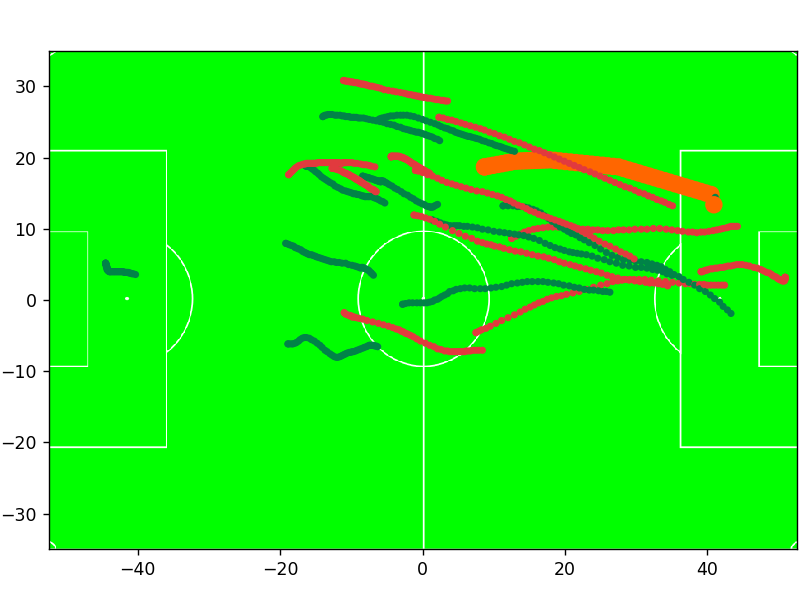

In [98]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

# directories
# CHANGE HERE
data_dir = ''
game_dir = data_dir
court_path = data_dir + 'soccer_field_cropped.png'
fig = plt.figure()
ax = plt.gca() #create axis object
img = mpimg.imread(court_path)  # read image. I got this image from gmf05's github.

plt.imshow(img, extent=[-52.5,52.5,-35,35], zorder=0)
color_dict = {
    'attacking': '#E13A3E',
    'defending': '#008348'
}


def function_to_draw_figure(jj):
  # show the image.

    ball = balls[jj,:].reshape(-1)
    att_player = attacking_players[jj,:].reshape(-1)
    def_player=defending_players[jj,:].reshape(-1)

    for i in range(11):

        xx=att_player[2*i]
        yy=att_player[1+2*i]
        print(xx,yy)
        player_circ_att = plt.Circle((xx,yy),0.5,
                        facecolor=color_dict['attacking'])
        ax.add_artist(player_circ_att)

        xx=def_player[2*i]
        yy=def_player[1+2*i]
        player_circ_def = plt.Circle((xx,yy),0.5,
                        facecolor=color_dict['defending'])
        ax.add_artist(player_circ_def)



    ball_circ = plt.Circle((ball[0], ball[1]),1.1, color=[1, 0.4, 0])  # create circle object for bal
    ax.add_artist(ball_circ)
    plt.xlim([-52.5,52.5])
    plt.ylim([-35,35])

    plt.tight_layout(pad=0, w_pad=0.5, h_pad=0)



ani = FuncAnimation(plt.gcf(), function_to_draw_figure, frames=50, 
                    interval=100, repeat=False)

plt.show()

In [7]:
# normalize the data
normalized = np.copy(mat)
normalized[:,:,::2] = normalized[:,:,::2] / 52.5
normalized[:,:,1::2] = normalized[:,:,1::2] / 34

In [8]:
#get distance from ball for each player and store as a matrix
ball_dist = np.copy(normalized)
ball_dist[:,:,::2] = (ball_dist[:,:,::2].T - ball_dist[:,:,-2].T).T
ball_dist[:,:,1::2] = (ball_dist[:,:,1::2].T - ball_dist[:,:,-1].T).T
# get ball distances of players only
ball_dist = ball_dist[:,:,:-2]

In [9]:
# get the velocities
vel = mat[:,1:] - mat[:,:-1]
zero_vec = np.zeros((38, 1, 46))
vel = np.concatenate((zero_vec, vel), axis=1)
vel.shape
# normalize the player and ball velocities separately
# playervel_mean_x = np.mean(vel[:,:,:-2:2])
# playervel_std_x = np.std(vel[:,:,:-2:2])
# playervel_mean_y = np.mean(vel[:,:,1:-2:2])
# playervel_std_y = np.std(vel[:,:,1:-2:2])
# ballvel_mean_x = np.mean(vel[:,:,-2])
# bellvel_std_x = np.std(vel[:,:,-2])
# ballvel_mean_y = np.mean(vel[:,:,-1])
# bellvel_std_y = np.std(vel[:,:,-1])
# vel[:,:,:-2:2] = (vel[:,:,:-2:2] - playervel_mean_x) / playervel_std_x
# vel[:,:,1:-2:2] = (vel[:,:,1:-2:2] - playervel_mean_y) / playervel_std_y
# vel[:,:,-2] = (vel[:,:,-2] - ballvel_mean_x) / bellvel_std_x
# vel[:,:,-1] = (vel[:,:,-1] - ballvel_mean_y) / bellvel_std_y

(38, 50, 46)

In [10]:
# concat normalized positions and ball distances into a single vector of length(46+44). This is data for the LSTM
lstm_data = np.concatenate((normalized, ball_dist), axis = 2)
np.save('lstm_test1_data.npy', lstm_data)
lstm_data.shape

(38, 50, 90)

In [11]:
# check for instances where player-ball interactions take place i.e. ball_dist = 0
interactions = (ball_dist[:,:,::2] == 0) * (ball_dist[:,:,1::2] == 0)
interactions = np.sum(interactions, axis=2)
interactions = interactions.astype(int)
np.save('interactions_test1.npy', interactions)
interactions.shape

(38, 50)

In [12]:
# Sequences with no interactions
np.arange(38)[np.sum(interactions,axis=1) == 0]

array([11, 13])

In [13]:
# data for FCN(same data in a more suitable format)
position_x = normalized[:,:,::2]
position_y = normalized[:,:,1::2]
ball_dist_x = ball_dist[:,:,::2]
ball_dist_y = ball_dist[:,:,1::2]
vel_x = vel[:,:,::2]
vel_y = vel[:,:,1::2]
player_indices = np.zeros((38,50,22))
player_indices[:,:,:] = np.arange(22)
distances = np.sqrt(ball_dist_x**2 + ball_dist_y**2)
position_x.shape, position_y.shape, ball_dist_x.shape, ball_dist_y.shape, vel_x.shape, vel_y.shape, distances.shape

C:\Users\vishw\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


((38, 50, 23),
 (38, 50, 23),
 (38, 50, 22),
 (38, 50, 22),
 (38, 50, 23),
 (38, 50, 23),
 (38, 50, 22))

In [14]:
# check the number of players in the context area when player-ball interaction takes place
context = 10 / 34
fcn = []
for i in range(38):
    for j in range(50):
        if interactions[i,j] > 0:
            fcn.append(np.sum((np.abs(ball_dist_x[i,j,:]) < context) * (np.abs(ball_dist_y[i,j,:]) < context)))
fcn = np.array(fcn)
np.mean(fcn)

6.245614035087719

In [15]:
mask = (np.abs(ball_dist_x) < context) * (np.abs(ball_dist_y) < context)

In [16]:
fcn_data = np.zeros((38, 50, 44))
prediction_indices = np.zeros((38, 50))
for i in range(38):
    for j in range(50):
        if interactions[i,j] > 0:
            insta_ball_dist = distances[i,j][mask[i,j]]
            insta_indices = np.argsort(insta_ball_dist)
            insta_player_indices = player_indices[i,j][mask[i,j]][insta_indices]
            prediction_indices[i,j] = insta_player_indices[0]
            insta_pos_x = normalized[:,:,:-2:2][i,j][mask[i,j]][insta_indices]
            insta_pos_y = normalized[:,:,1:-2:2][i,j][mask[i,j]][insta_indices]        
            insta_ball_x = ball_dist_x[i,j][mask[i,j]][insta_indices]
            insta_ball_y = ball_dist_y[i,j][mask[i,j]][insta_indices]
            insta_velocity_x = vel_x[:,:,:-1][i,j][mask[i,j]][insta_indices]
            insta_velocity_y = vel_y[:,:,:-1][i,j][mask[i,j]][insta_indices]
            fcn_data[i,j,0] = normalized[i,j,-2]
            fcn_data[i,j,1] = normalized[i,j,-1]
            fcn_data[i,j,2] = vel_x[i,j,-1]
            fcn_data[i,j,3] = vel_y[i,j,-1]
            fcn_data[i,j,4] = insta_pos_x[0]
            fcn_data[i,j,5] = insta_pos_y[0]
            fcn_data[i,j,6] = insta_velocity_x[0]
            fcn_data[i,j,7] = insta_velocity_y[0]
            fcn_data[i,j,8] = -1 if insta_player_indices[0] <= 10 else 1
            c = 1
            e = 9
            for d in range(1,len(insta_indices)):
                fcn_data[i,j,e] = insta_pos_x[d]
                fcn_data[i,j,e+1] = insta_pos_y[d]
                fcn_data[i,j,e+2] = insta_ball_x[d]
                fcn_data[i,j,e+3] = insta_ball_y[d]
                fcn_data[i,j,e+4] = insta_velocity_x[d]
                fcn_data[i,j,e+5] = insta_velocity_y[d]
                fcn_data[i,j,e+6] = -1 if insta_player_indices[d] <= 10 else 1
                e += 7
                c += 1
                if c == 6:
                    break
np.save('fcn_test1_data.npy', fcn_data)
prediction_indices = prediction_indices.astype(int)
np.save('prediction_indices_test1.npy', prediction_indices)

In [92]:
output = np.load('_test1_output.npy')
output.shape

(38, 50, 46)

In [93]:
# rescaling
rescale = np.copy(output)
rescale[:,:,::2] = rescale[:,:,::2] * 52.5
rescale[:,:,1::2] = rescale[:,:,1::2] * 34

In [100]:
attacking_players=rescale[18,:,:22]
defending_players=rescale[18,:,22:44]
balls=rescale[18,:,44:]

<IPython.core.display.Javascript object>


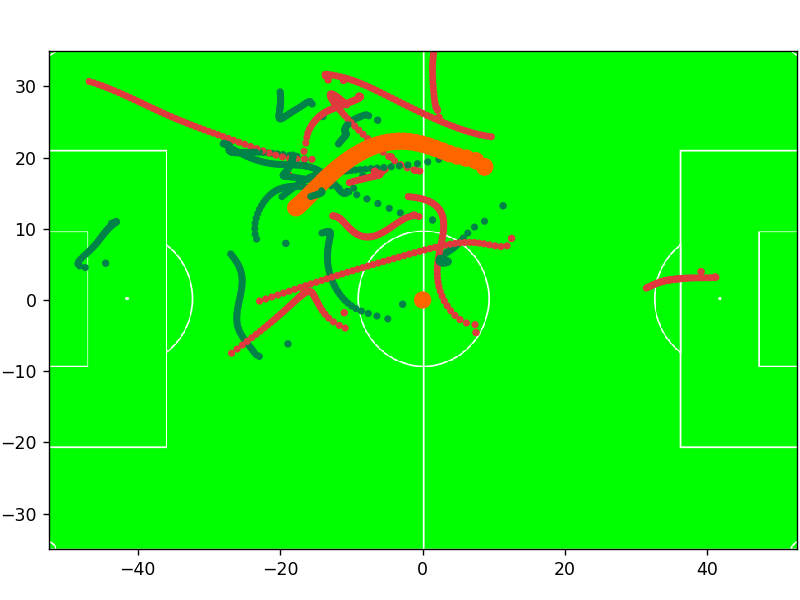

In [102]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

# directories
# CHANGE HERE
data_dir = ''
game_dir = data_dir
court_path = data_dir + 'soccer_field_cropped.png'
fig = plt.figure()
ax = plt.gca() #create axis object
img = mpimg.imread(court_path)  # read image. I got this image from gmf05's github.

plt.imshow(img, extent=[-52.5,52.5,-35,35], zorder=0)
color_dict = {
    'attacking': '#E13A3E',
    'defending': '#008348'
}


def function_to_draw_figure(jj):
  # show the image.

    ball = balls[jj,:].reshape(-1)
    att_player = attacking_players[jj,:].reshape(-1)
    def_player=defending_players[jj,:].reshape(-1)

    for i in range(11):

        xx=att_player[2*i]
        yy=att_player[1+2*i]
        print(xx,yy)
        player_circ_att = plt.Circle((xx,yy),0.5,
                        facecolor=color_dict['attacking'])
        ax.add_artist(player_circ_att)

        xx=def_player[2*i]
        yy=def_player[1+2*i]
        player_circ_def = plt.Circle((xx,yy),0.5,
                        facecolor=color_dict['defending'])
        ax.add_artist(player_circ_def)



    ball_circ = plt.Circle((ball[0], ball[1]),1.1, color=[1, 0.4, 0])  # create circle object for bal
    ax.add_artist(ball_circ)
    plt.xlim([-52.5,52.5])
    plt.ylim([-35,35])

    plt.tight_layout(pad=0, w_pad=0.5, h_pad=0)



ani = FuncAnimation(plt.gcf(), function_to_draw_figure, frames=50, 
                    interval=100, repeat=False)

plt.show()